In [2]:
import boto3
from dotenv import load_dotenv
import os
import logging
import matplotlib.pyplot as plt
from typing import Dict, Any, Optional, List
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use("ggplot")

# Configure the logging system
logging.basicConfig(
    level=logging.INFO # We set the logging level to INFO so that INFO and above messages are logged
)

logger = logging.getLogger(__name__)

load_dotenv()

True

In [4]:
LOCAL_DIR = "data"
        
os.makedirs(LOCAL_DIR, exist_ok=True)

In [3]:
# Read keys from environment (Zrive keys)
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
bucket = os.getenv("S3_BUCKET")

# Create boto3 client using those keys
s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

In [6]:
bucket = "zrive-ds-data"
# prefix = "groceries/sampled-datasets/"
prefix = ""

# Create boto3 client using those keys
s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

s3_client.list_objects_v2(
    Bucket=bucket,
    Prefix=prefix)

{'ResponseMetadata': {'RequestId': 'TGC23SKK8YKWB4BB',
  'HostId': 'HGrFj1wfJZbJBzp238D7n74+8t/8d4ribnTm+CqrJO3rKX/nS0rY2UkMKgNfq79i1VQ8cZjcZBg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'HGrFj1wfJZbJBzp238D7n74+8t/8d4ribnTm+CqrJO3rKX/nS0rY2UkMKgNfq79i1VQ8cZjcZBg=',
   'x-amz-request-id': 'TGC23SKK8YKWB4BB',
   'date': 'Tue, 14 Oct 2025 21:23:00 GMT',
   'x-amz-bucket-region': 'eu-west-1',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 1},
 'IsTruncated': False,
 'Contents': [{'Key': 'groceries/box_builder_dataset/feature_frame.csv',
   'LastModified': datetime.datetime(2023, 9, 23, 12, 6, 2, tzinfo=tzutc()),
   'ETag': '"0305fd249157254397ad3e88bd2c2662-91"',
   'Size': 761678715,
   'StorageClass': 'STANDARD'},
  {'Key': 'groceries/sampled-datasets/abandoned_carts.parquet',
   'LastModified': datetime.datetime(2023, 9, 3, 13, 10, 5, tzinfo=tzutc()),
   'ETag': '"772fcd2edcd9bccba75490bb7935f5a1"',

In [6]:
# List objects in the bucket to see what's there. I have commented it because it no longer lets me list objects from the bucket, as the user I'm using doesn´t have the permission


# response = s3_client.list_objects(Bucket=bucket)

# s3_file_paths = []

# for item in response['Contents']: 
#     if "parquet" in item['Key']:
#         s3_file_paths.append(item['Key']) 


def download_file_from_s3(
        s3_client: boto3.client, 
        bucket_name: str, 
        s3_key: str, 
        local_dir: Optional[str] = LOCAL_DIR
        ):
    """
    This function downloads a file from an S3 bucket to a local directory.  
    """
    if not os.path.exists(local_dir):
        logger.info(f"Directory {local_dir} does not exist. Creating it.")  
        os.makedirs(local_dir)
        logger.info(f"Created directory {local_dir}")   

    local_path = os.path.join(local_dir, os.path.basename(s3_key)) # basename gets the last part of the path
    
    s3_client.download_file(
        Bucket=bucket_name,
        Key=s3_key,
        Filename=local_path
    )

    logger.info(f"Downloaded {s3_key} to {local_path}") 

# Let's download and save the files locally

# for file in s3_file_paths:
#     download_file_from_s3(
#         s3_client=s3_client, 
#         bucket_name=bucket, 
#         s3_key=file, 
#         local_dir=LOCAL_DIR
#     )

In [7]:
os.listdir(LOCAL_DIR)

['users.parquet',
 'regulars.parquet',
 'inventory.parquet',
 'orders.parquet',
 'abandoned_carts.parquet']

In [ ]:
# Now let's read .parquet files

local_file_paths = [
    os.path.join(LOCAL_DIR, file)
    for file in os.listdir(LOCAL_DIR)
    if file.endswith(".parquet")
]


local_file_paths

['data/raw/users.parquet',
 'data/raw/regulars.parquet',
 'data/raw/inventory.parquet',
 'data/raw/orders.parquet',
 'data/raw/abandoned_carts.parquet']

## Data Files Description  

The data comes from a **groceries e-commerce platform** (think of it as an online supermarket) and is partitioned across multiple datasets:  

- **abandoned_cart.parquet**  
  Captures items left in a user’s basket but not purchased.  
  - `item_ids` column contains the list of abandoned items.  
- **inventory.parquet**  
  Metadata about each `item_id`.  
  - Provides product-level information (e.g., product details, attributes). 
- **orders.parquet**  
  Order history of customers.  
  - Each row = one order.  
  - `item_ids` column stores the list of items in that order.  
- **regulars.parquet**  
  Items that users have marked as *regular purchases*.  
  - Each row links a user with the items they want to receive regularly.  
  - Includes the timestamp when the user set that preference.  
- **users.parquet**  
  Information about users.  
  - Contains user-specific attributes (demographics, account info, etc.).  


In [9]:
# We now store all .parquet files in a dict, where keys are the file name and the values are the corresponding the dfs
dfs = {
    f.replace(".parquet", ""): pd.read_parquet(os.path.join(LOCAL_DIR, f)) # { key : value for vars in iterable }
    for f in os.listdir(LOCAL_DIR)
    if f.endswith(".parquet")
}

dfs.keys()

dict_keys(['users', 'regulars', 'inventory', 'orders', 'abandoned_carts'])

In [10]:
for df in dfs.values():
    print(df.select_dtypes(include="object").columns)

Index(['user_id', 'user_segment', 'user_nuts1', 'first_ordered_at',
       'customer_cohort_month'],
      dtype='object')
Index(['user_id'], dtype='object')
Index(['vendor', 'product_type', 'tags'], dtype='object')
Index(['user_id', 'ordered_items'], dtype='object')
Index(['user_id', 'variant_id'], dtype='object')


In [11]:
orders = dfs["orders"]
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB


In [12]:
orders.tail()

,id,user_id,created_at,order_date,user_order_seq,ordered_items
64396,4026096910468,f524eaf26b76bc6226747768f120ffcd23d5c3d52a0a19...,2022-03-13 10:14:22,2022-03-13,5,"[33981947707524, 34284951273604, 3428495127360..."
64488,4026464993412,aa5e21db3186dcd84c161719c5ade8a19adb853ea8bfef...,2022-03-13 18:30:31,2022-03-13,3,"[33803540725892, 34284950519940, 3437091504141..."
64499,4026553434244,14be3833c19e0a1fd7e6db0e5375a3d1dcc9efafcb0e69...,2022-03-13 20:11:50,2022-03-13,11,"[39283356663940, 39283356663940, 4015514504410..."
64523,4026656030852,500027bf392bfa9ef527919569fba44904d429155b7cf4...,2022-03-13 22:29:24,2022-03-13,4,"[33824368033924, 33824368033924, 3382436803392..."
64538,4026732413060,faaad4bc113fe7e0a888a0d3535877d3c692f591882c25...,2022-03-14 00:24:59,2022-03-14,3,"[33826472558724, 34037939437700, 3428495186342..."


In [13]:
users = dfs["users"]
users

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3011,2c0eaa81411d8796e4e28a1a13265aa773e815d83e6db1...,Proposition,UKH,2022-01-18 10:10:39,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4343,bf8da3ba3538396b70564a49f55f26303af645a0fe32fa...,Top Up,UKI,2021-11-02 09:24:55,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2725,b1892f28d8bb191138ec1f098a8e229c16755f2616aea0...,Top Up,UKM,2021-06-10 12:46:07,2021-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4340,2745667201081b389e4b290565d17651b3eb94d9077183...,Proposition,UKI,2021-01-10 11:07:16,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB


In [15]:
users.dropna().head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
4751,09d70e0b0778117aec5550c08032d56f8e06f992741680...,Proposition,UKI,2021-06-28 12:07:04,2021-06-01 00:00:00,1.0,1.0,0.0,0.0,0.0
3154,4f5ff38ce5ed48096ba80dff80e167db1ad24b9ebdb00c...,Top Up,UKD,2020-06-12 12:07:35,2020-06-01 00:00:00,3.0,2.0,0.0,1.0,0.0
736,7b2ae50bb11646436fa613394fc3e71e1a0cdc3ba30cdb...,Proposition,UKF,2020-10-03 09:53:57,2020-10-01 00:00:00,2.0,2.0,0.0,0.0,2.0
4792,5e977a4aa2c57f306b8a22f92eaaa177f7dc31a52df82c...,Proposition,UKI,2021-10-14 10:41:13,2021-10-01 00:00:00,2.0,1.0,1.0,0.0,1.0
2217,eafb89ad33eb377adb98a915b6a5a65f1284c2db517d07...,Proposition,UKH,2022-01-20 15:53:09,2022-01-01 00:00:00,2.0,2.0,0.0,0.0,0.0


In [16]:
regulars = dfs["regulars"]
regulars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB


In [17]:
regulars.head()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


In [350]:
inventory = dfs["inventory"]
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB


In [19]:
inventory.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In [20]:
abandoned_carts = dfs["abandoned_carts"]
abandoned_carts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[us]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 213.2+ KB


In [21]:
abandoned_carts.head() # variant_id is a list of items id, whereas in "regulars", variant_id is a single item

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326..."
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


## Analysis

1. Profiling buyer population
2. Analyse regular products
3. Purchase pattern: reconstruct orders and abandoned orders with inventory info.

#### 1. Profiling customers

In [22]:
regulars

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11
...,...,...,...
37644,20a41b8fa616484b39812aaa377ea1b53247f6941c0586...,39265878999172,2022-03-13 16:02:13
37717,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,39459281272964,2022-03-14 07:49:24
37718,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,33973246951556,2022-03-14 07:49:24
37719,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,39587297656964,2022-03-14 07:49:24


In [23]:
n_regulars = (
    regulars.groupby("user_id")["variant_id"]
    .nunique()
    .reset_index()
    .rename(columns={"variant_id":"n_regulars"})
)

n_regulars

,user_id,n_regulars
0,004b3e3cb9a9f5b0974ce4179db394057c72e7a82077bf...,1
1,005743eefffa4ce840608c4f47b8c548b134d89be5c390...,2
2,0074992079c1836c6509eec748a973dc97388b4877e770...,24
3,00ecced73edb11d4bab08e794656dcf9d9b89ea89c5918...,3
4,014301579c18e7c7f034e544ab3d4ee235ef2de43ee5db...,5
...,...,...
1443,ffa3abfc6751ea918862db07a350c6bf079e6d7978e94e...,2
1444,ffa4074b5e096673f7763abfb08e33c94cd1973be4971e...,5
1445,ffc82cb5b4dbc39ebba1f6ab925b995f28f7e1826f5d97...,22
1446,fffc1d81bbde7ce58c679994aa863323198ff6a3afef4c...,1


In [24]:
users = dfs["users"]
users = users.merge(n_regulars, on="user_id", how="left").fillna({"n_regulars":0})
users

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
0,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
1,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
2,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
3,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4978,2c0eaa81411d8796e4e28a1a13265aa773e815d83e6db1...,Proposition,UKH,2022-01-18 10:10:39,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.0
4979,bf8da3ba3538396b70564a49f55f26303af645a0fe32fa...,Top Up,UKI,2021-11-02 09:24:55,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4980,b1892f28d8bb191138ec1f098a8e229c16755f2616aea0...,Top Up,UKM,2021-06-10 12:46:07,2021-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4981,2745667201081b389e4b290565d17651b3eb94d9077183...,Proposition,UKI,2021-01-10 11:07:16,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,8.0


In [25]:
users.dropna()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
23,09d70e0b0778117aec5550c08032d56f8e06f992741680...,Proposition,UKI,2021-06-28 12:07:04,2021-06-01 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0
27,4f5ff38ce5ed48096ba80dff80e167db1ad24b9ebdb00c...,Top Up,UKD,2020-06-12 12:07:35,2020-06-01 00:00:00,3.0,2.0,0.0,1.0,0.0,1.0
28,7b2ae50bb11646436fa613394fc3e71e1a0cdc3ba30cdb...,Proposition,UKF,2020-10-03 09:53:57,2020-10-01 00:00:00,2.0,2.0,0.0,0.0,2.0,25.0
35,5e977a4aa2c57f306b8a22f92eaaa177f7dc31a52df82c...,Proposition,UKI,2021-10-14 10:41:13,2021-10-01 00:00:00,2.0,1.0,1.0,0.0,1.0,72.0
66,eafb89ad33eb377adb98a915b6a5a65f1284c2db517d07...,Proposition,UKH,2022-01-20 15:53:09,2022-01-01 00:00:00,2.0,2.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
4823,2af3b4045f9720d7ecff437c541235a9cffc5d970e819d...,Top Up,UKI,2020-11-23 13:39:49,2020-11-01 00:00:00,5.0,2.0,3.0,0.0,0.0,0.0
4864,9d04b5e14e261ceeeff21ff4da607a5ffd893cb1df3947...,Top Up,UKH,2021-04-08 08:08:29,2021-04-01 00:00:00,1.0,1.0,0.0,0.0,0.0,1.0
4899,83e6fbcad49822b289f2fb425f973f48d0684dec6cbab4...,Top Up,UKK,2020-08-23 10:30:29,2020-08-01 00:00:00,3.0,2.0,1.0,0.0,0.0,5.0
4940,84db2fef5efda066b372af2c93419262dab69f40bb2f94...,Proposition,UKF,2020-08-22 03:51:23,2020-08-01 00:00:00,2.0,1.0,1.0,0.0,1.0,23.0


In [26]:
users.describe()

,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
count,325.000000,325.000000,325.000000,325.000000,325.000000,4983.000000
mean,2.787692,2.003077,0.707692,0.076923,0.636923,2.481437
std,1.365753,0.869577,1.026246,0.289086,0.995603,8.890588
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,1.000000,0.000000,1.000000,1.000000
max,8.000000,7.000000,6.000000,2.000000,6.000000,320.000000


Se observa que el 50% tiene 0 regulars y que el 75% tiene al menos 1 item regular. La distribución está muy sesgada hacia la derecha. Esto significa que hay un pequeño porcentaje de users que concentra un gran número de regulars

<Axes: xlabel='count_babies'>

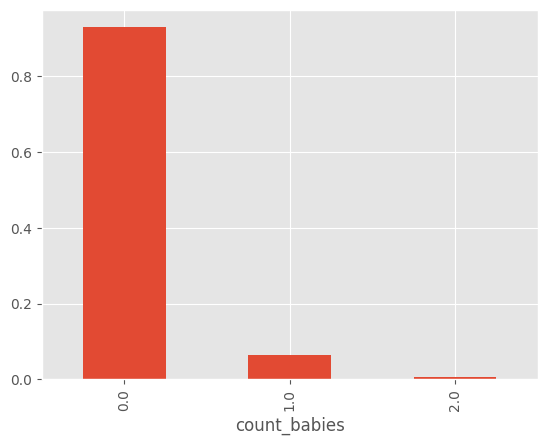

In [27]:
users.count_babies.value_counts(normalize=True).sort_index().plot(kind="bar")

In [28]:
users

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
0,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
1,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
2,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
3,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4978,2c0eaa81411d8796e4e28a1a13265aa773e815d83e6db1...,Proposition,UKH,2022-01-18 10:10:39,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.0
4979,bf8da3ba3538396b70564a49f55f26303af645a0fe32fa...,Top Up,UKI,2021-11-02 09:24:55,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4980,b1892f28d8bb191138ec1f098a8e229c16755f2616aea0...,Top Up,UKM,2021-06-10 12:46:07,2021-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4981,2745667201081b389e4b290565d17651b3eb94d9077183...,Proposition,UKI,2021-01-10 11:07:16,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,8.0


<Axes: xlabel='count_adults'>

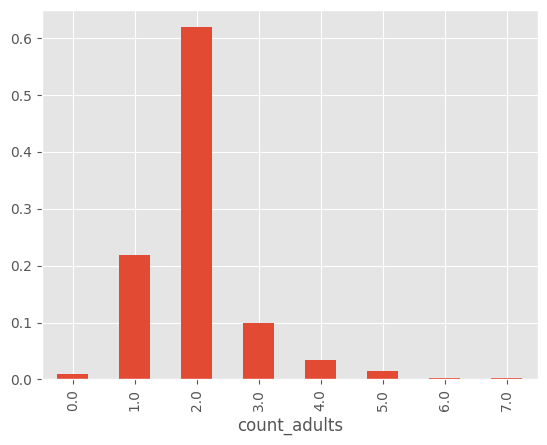

In [29]:
users.count_adults.value_counts(normalize=True).sort_index().plot(kind="bar")

In [30]:
users.dropna().head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
23,09d70e0b0778117aec5550c08032d56f8e06f992741680...,Proposition,UKI,2021-06-28 12:07:04,2021-06-01 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0
27,4f5ff38ce5ed48096ba80dff80e167db1ad24b9ebdb00c...,Top Up,UKD,2020-06-12 12:07:35,2020-06-01 00:00:00,3.0,2.0,0.0,1.0,0.0,1.0
28,7b2ae50bb11646436fa613394fc3e71e1a0cdc3ba30cdb...,Proposition,UKF,2020-10-03 09:53:57,2020-10-01 00:00:00,2.0,2.0,0.0,0.0,2.0,25.0
35,5e977a4aa2c57f306b8a22f92eaaa177f7dc31a52df82c...,Proposition,UKI,2021-10-14 10:41:13,2021-10-01 00:00:00,2.0,1.0,1.0,0.0,1.0,72.0
66,eafb89ad33eb377adb98a915b6a5a65f1284c2db517d07...,Proposition,UKH,2022-01-20 15:53:09,2022-01-01 00:00:00,2.0,2.0,0.0,0.0,0.0,3.0


In [31]:
users.loc[lambda x: x.n_regulars < 100].n_regulars.describe()
# Its the same as "users.loc[users.n_regulars < 100].n_regulars"

count    4981.000000
mean        2.396105
std         7.516721
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        90.000000
Name: n_regulars, dtype: float64

In [32]:
# What % of users has more than 10 regulars?
users.loc[lambda df: df.n_regulars > 10].n_regulars.size/len(users) 


0.07264699979931769

Text(0.5, 1.0, 'Average nº of regulars per user segment')

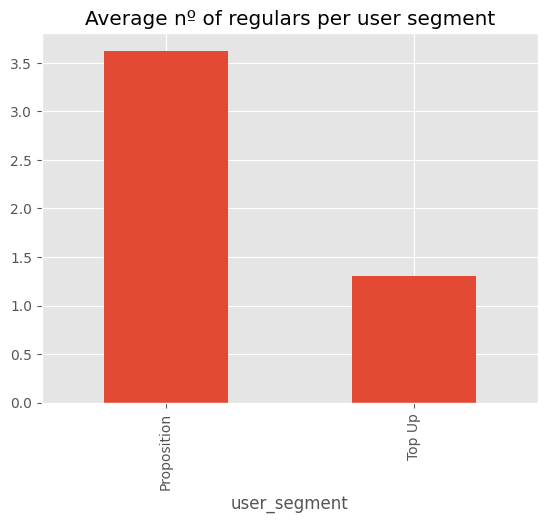

In [33]:
users[users.n_regulars < 100].groupby("user_segment").n_regulars.mean().plot(kind="bar")
plt.title("Average nº of regulars per user segment")

We can observe how "Proposition" user segment has more regulars saved. "Proposition" users appear to have more engagement, however, we cannot make direct assumptions, as there is little information about the criteria used to classify users into the Proposition or Top-up segments

In [34]:
users.dropna().head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
23,09d70e0b0778117aec5550c08032d56f8e06f992741680...,Proposition,UKI,2021-06-28 12:07:04,2021-06-01 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0
27,4f5ff38ce5ed48096ba80dff80e167db1ad24b9ebdb00c...,Top Up,UKD,2020-06-12 12:07:35,2020-06-01 00:00:00,3.0,2.0,0.0,1.0,0.0,1.0
28,7b2ae50bb11646436fa613394fc3e71e1a0cdc3ba30cdb...,Proposition,UKF,2020-10-03 09:53:57,2020-10-01 00:00:00,2.0,2.0,0.0,0.0,2.0,25.0
35,5e977a4aa2c57f306b8a22f92eaaa177f7dc31a52df82c...,Proposition,UKI,2021-10-14 10:41:13,2021-10-01 00:00:00,2.0,1.0,1.0,0.0,1.0,72.0
66,eafb89ad33eb377adb98a915b6a5a65f1284c2db517d07...,Proposition,UKH,2022-01-20 15:53:09,2022-01-01 00:00:00,2.0,2.0,0.0,0.0,0.0,3.0


In [35]:
users.user_segment.value_counts(normalize=False)

user_segment
Top Up         2643
Proposition    2340
Name: count, dtype: int64

In [36]:
users[users.n_regulars < 100].groupby("user_segment").n_regulars.mean()

user_segment
Proposition    3.625321
Top Up         1.308740
Name: n_regulars, dtype: float64

In [37]:
users

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
0,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
1,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
2,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
3,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4978,2c0eaa81411d8796e4e28a1a13265aa773e815d83e6db1...,Proposition,UKH,2022-01-18 10:10:39,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.0
4979,bf8da3ba3538396b70564a49f55f26303af645a0fe32fa...,Top Up,UKI,2021-11-02 09:24:55,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4980,b1892f28d8bb191138ec1f098a8e229c16755f2616aea0...,Top Up,UKM,2021-06-10 12:46:07,2021-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4981,2745667201081b389e4b290565d17651b3eb94d9077183...,Proposition,UKI,2021-01-10 11:07:16,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,8.0


In [38]:
users.columns

Index(['user_id', 'user_segment', 'user_nuts1', 'first_ordered_at',
       'customer_cohort_month', 'count_people', 'count_adults',
       'count_children', 'count_babies', 'count_pets', 'n_regulars'],
      dtype='object')

In [39]:
family_cols = [col for col in users.columns if col.startswith("count_")]
family_inputs = users.count_people.dropna().count()

family_d = {f"any_{col}": (users[col]>0).sum() / family_inputs for col in family_cols}
family_d

{'any_count_people': 0.9938461538461538,
 'any_count_adults': 0.9907692307692307,
 'any_count_children': 0.4,
 'any_count_babies': 0.07076923076923076,
 'any_count_pets': 0.40615384615384614}

In [40]:
family_info = family_inputs/len(users) # De todas las entradas, cuantas tienen información de familia
family_info

0.06522175396347582

De todas las entradas (que representarían una familia o household) que tenemos información:
- El 99.38% tienen al menos 1 persona, lo cual es extraño por que debería ser el 100%
- El 99.07% tienen al menos 1 adulto
- El 40% tienen niños
- El 7.08% tienen bebés
- El 40.62% tienen mascotas

In [41]:
(
    users[["count_pets","count_babies","count_children"]].sum(axis=1) > 0
).sum() / family_inputs

0.6123076923076923

<Axes: xlabel='user_nuts1'>

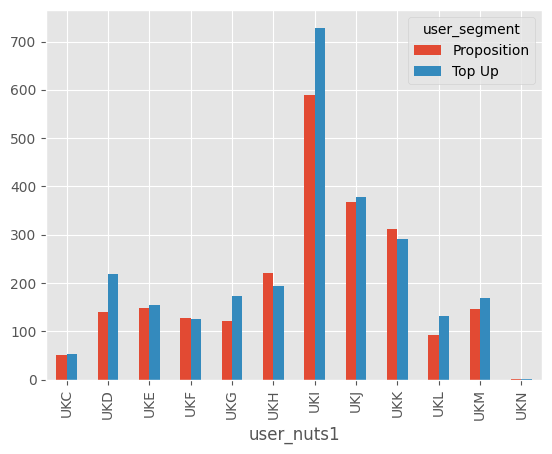

In [42]:
pd.crosstab(users.user_nuts1, users.user_segment).plot(kind="bar")

#### Insights

- La mayoría de los usuarios no tienen "regular products"; sólo el 7% tiene más de 10
- Los usuarios de "Proposition" tienen de media hasta 3 veces más regulars que los "Top-up"
- De todas las entradas, sólo el 6.5% tienen información del household o la familia (el resto tiene datos nulos)
- La población está formada en su mayoría por "familias" de 2 o más adultos (1 solo adulto <25%)
- El 60% de las familias tienen al menos children, babies o pets
- Sólo el 7% tienen bebés

### 2. Understanding regular products

In [43]:
regulars_df = regulars.merge(inventory, how="left", on="variant_id")
regulars_df

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
0,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
1,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
2,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
3,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,3.49,3.50,method,cleaning-products,"[cruelty-free, eco, vegan, window-glass-cleaner]"
...,...,...,...,...,...,...,...,...
18100,20a41b8fa616484b39812aaa377ea1b53247f6941c0586...,39265878999172,2022-03-13 16:02:13,2.59,2.75,oceansaver,cleaning-products,"[all-purpose-cleaner, cruelty-free, eco, vegan]"
18101,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,39459281272964,2022-03-14 07:49:24,4.49,9.00,cif,cleaning-products,"[bathroom-limescale-cleaner, refills]"
18102,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,33973246951556,2022-03-14 07:49:24,2.69,2.75,marigold,cleaning-products,[sponges-cloths-gloves]
18103,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,39587297656964,2022-03-14 07:49:24,4.19,4.29,cooksco,cooking-ingredients,"[christmas, discontinue, gluten-free, oils]"


In [44]:
regulars_df.head()

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
0,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
1,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
2,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
3,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,3.49,3.5,method,cleaning-products,"[cruelty-free, eco, vegan, window-glass-cleaner]"


<Axes: xlabel='created_at'>

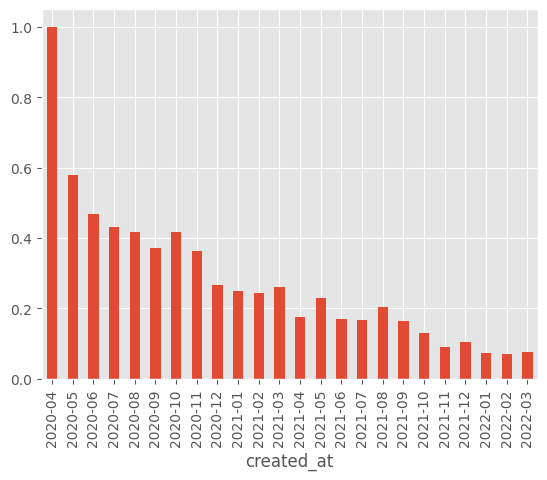

In [45]:
regulars_df.groupby(
    regulars_df.created_at.dt.to_period("M")
)["price"].apply(
    lambda df: df.isna().sum()/len(df)
).plot(kind="bar")

Esta función agrupa el df regulars_df por la columna created_at, y la convierte a "month". Después selecciona la columna "price" (para cada month) y obtiene la proporción de valores nulos en cada mes.

En otras palabras: “¿Qué porcentaje de datos de precio falta cada mes?”

In [46]:
regulars_df

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
0,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
1,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
2,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
3,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,3.49,3.50,method,cleaning-products,"[cruelty-free, eco, vegan, window-glass-cleaner]"
...,...,...,...,...,...,...,...,...
18100,20a41b8fa616484b39812aaa377ea1b53247f6941c0586...,39265878999172,2022-03-13 16:02:13,2.59,2.75,oceansaver,cleaning-products,"[all-purpose-cleaner, cruelty-free, eco, vegan]"
18101,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,39459281272964,2022-03-14 07:49:24,4.49,9.00,cif,cleaning-products,"[bathroom-limescale-cleaner, refills]"
18102,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,33973246951556,2022-03-14 07:49:24,2.69,2.75,marigold,cleaning-products,[sponges-cloths-gloves]
18103,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,39587297656964,2022-03-14 07:49:24,4.19,4.29,cooksco,cooking-ingredients,"[christmas, discontinue, gluten-free, oils]"


In [47]:
regulars_df.isna().sum()

user_id                0
variant_id             0
created_at             0
price               3071
compare_at_price    3071
vendor              3071
product_type        3071
tags                3071
dtype: int64

In [48]:
clean_regulars = regulars_df.dropna()
clean_regulars

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,3.49,3.50,method,cleaning-products,"[cruelty-free, eco, vegan, window-glass-cleaner]"
8,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667182493828,2020-05-06 14:42:11,4.29,5.40,bulldog,skincare,"[cruelty-free, eco, facial-skincare, vegan]"
17,d883991facbc3b07b62da342d00c97d1e6cea8d2176695...,33667198910596,2020-07-06 10:12:08,14.99,16.55,ecover,dishwashing,"[cruelty-free, dishwasher-tablets, eco, vegan]"
18,66a195720d6988ff4d32155cc03631b84f68b34d3b0a1e...,33826459320452,2020-07-06 17:17:52,5.09,5.65,treeoflife,snacks-confectionery,"[christmas, nuts-dried-fruit-seeds, organic]"
19,0b7e02fee4b9e215da3bdae70050f20c5ffd18264454a5...,33667247276164,2020-07-18 16:56:55,2.49,3.00,method,hand-soap-sanitisers,"[cruelty-free, eco, hand-soap, vegan]"
...,...,...,...,...,...,...,...,...
18100,20a41b8fa616484b39812aaa377ea1b53247f6941c0586...,39265878999172,2022-03-13 16:02:13,2.59,2.75,oceansaver,cleaning-products,"[all-purpose-cleaner, cruelty-free, eco, vegan]"
18101,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,39459281272964,2022-03-14 07:49:24,4.49,9.00,cif,cleaning-products,"[bathroom-limescale-cleaner, refills]"
18102,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,33973246951556,2022-03-14 07:49:24,2.69,2.75,marigold,cleaning-products,[sponges-cloths-gloves]
18103,ba068a3398230c10a98868ced1fcc5b889b21e6f112fd0...,39587297656964,2022-03-14 07:49:24,4.19,4.29,cooksco,cooking-ingredients,"[christmas, discontinue, gluten-free, oils]"


<Axes: xlabel='variant_id'>

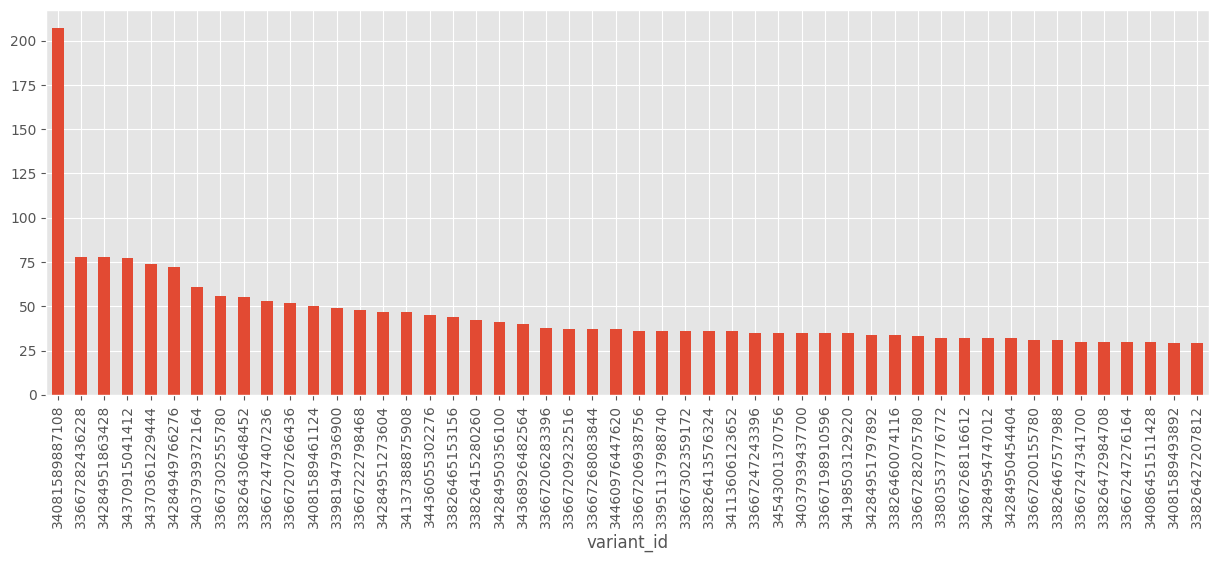

In [76]:
# Ahora vamos a ver la frecuencia con la que se guarda cad ítem "regular"
clean_regulars.groupby("variant_id")["user_id"].nunique().sort_values(
    ascending=False
).head(50).plot(kind="bar",figsize=(15,5))

Se observa que hay un ítem "regular" que destaca sobre el resto. Este ítem se guarda como "regular" hasta x3 veces más que el resto

In [83]:
top_product = (
    clean_regulars.groupby(clean_regulars.variant_id)["user_id"]
    .nunique()
    .sort_values(ascending=False)
    .head(1)
    .index[0]
)

top_product

34081589887108

In [345]:
clean_regulars.loc[clean_regulars.variant_id == top_product][
    ["variant_id","price","product_type","vendor"]
].head(1)

,variant_id,price,product_type,vendor
95,34081589887108,10.79,long-life-milk-substitutes,oatly


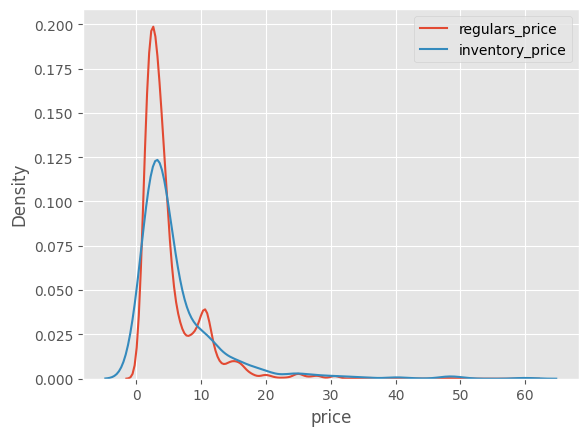

In [101]:
sns.kdeplot(clean_regulars.price, label="regulars_price")
sns.kdeplot(inventory.price, label="inventory_price")
plt.legend()

Text(0.5, 1.0, 'Top 50 vendors by number of regulars (out of 367 vendors)')

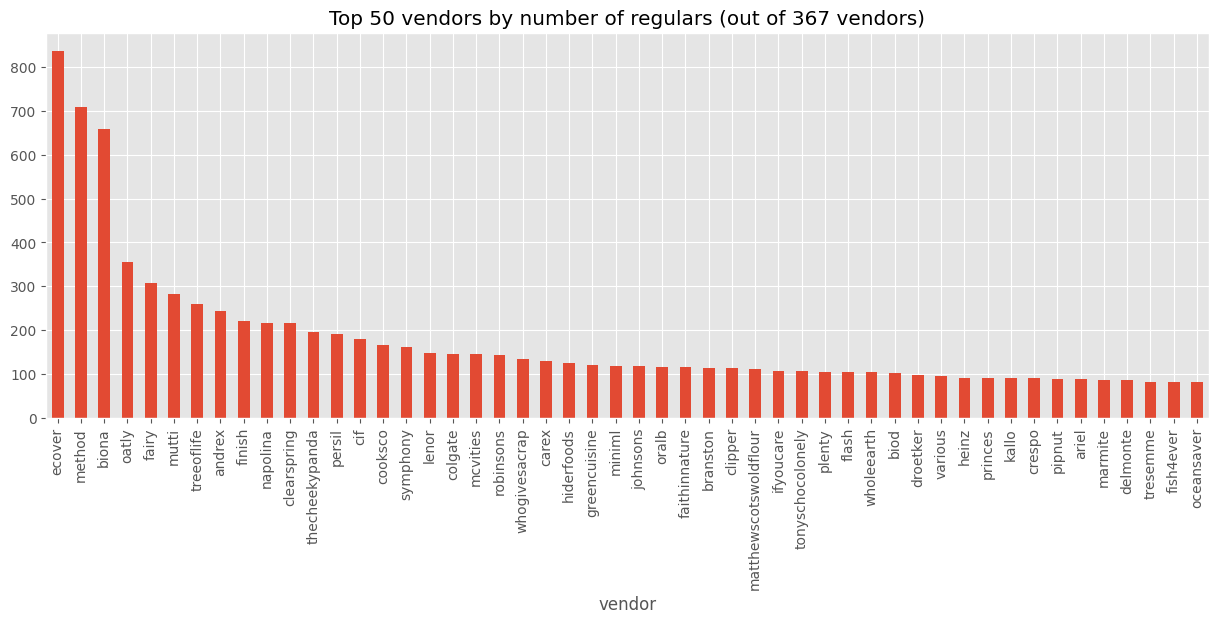

In [112]:
clean_regulars.vendor.value_counts().head(50).plot(kind="bar",figsize=(15,5))
plt.title(
    f"Top 50 vendors by number of regulars (out of {clean_regulars.vendor.nunique()} vendors)"
)

Text(0.5, 1.0, 'Top 30 product_type by number of products (out of 59 product_type)')

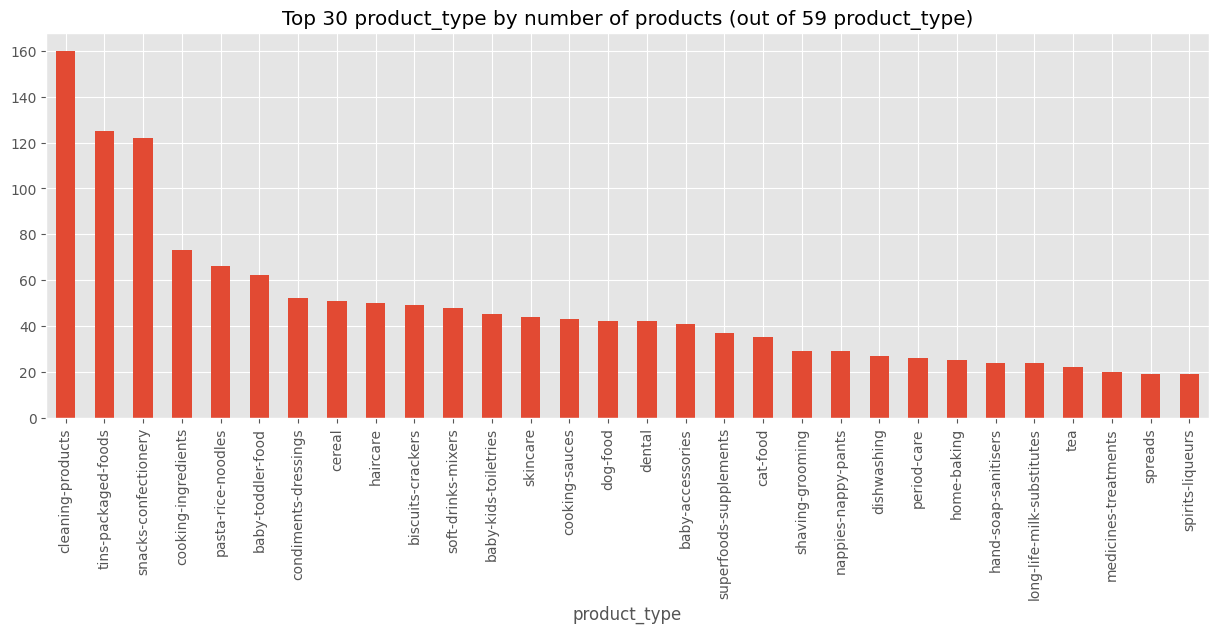

In [116]:
inventory.product_type.value_counts().head(30).plot(kind="bar",figsize=(15,5))
plt.title(
    f"Top 30 product_type by number of products (out of {inventory.product_type.nunique()} product_type)"
)

### Insights

1. La leche "oatly" es el top producto más "regular", es decir, el favorito de nuestros clientes
2. Las Top 3 marcas más vendidas (ecover, method y biona) son marcas eco-friendly, con lo cual no da información sobre el tipo de cliente que tenemos


In [141]:

clean_regulars.vendor.value_counts().head(3)

vendor
ecover    837
method    708
biona     659
Name: count, dtype: int64

### Orders

In [203]:
orders.user_id.nunique()

4983

In [204]:
orders.loc[lambda df:df.user_order_seq > 1].user_id.nunique()

1411

<Axes: xlabel='user_order_seq'>

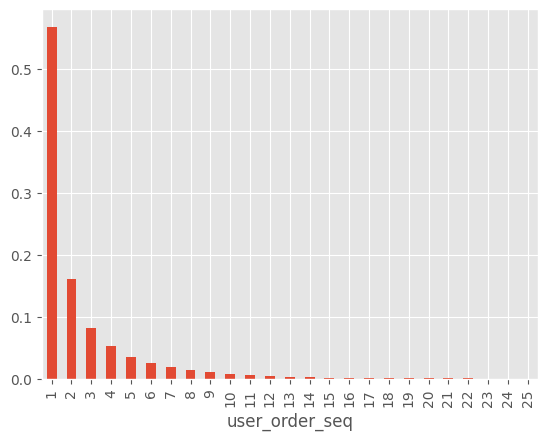

In [205]:
orders["user_order_seq"].value_counts(normalize=True).plot(kind="bar")

La mayor parte de usuarios sólo ha realizado 1 pedido (order)

In [206]:
orders.head(3)

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."


In [207]:
order_items = orders.explode("ordered_items").rename(
    {"ordered_items": "variant_id"}, axis=1
)
order_items.head()

,id,user_id,created_at,order_date,user_order_seq,variant_id
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618849693828
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618860179588
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618874040452
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060


In [208]:
inventory.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In [209]:
order_items =order_items.merge(inventory, how="left", on="variant_id")
order_items.head()

,id,user_id,created_at,order_date,user_order_seq,variant_id,price,compare_at_price,vendor,product_type,tags
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618849693828,NaN,NaN,NaN,NaN,NaN
1,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618860179588,NaN,NaN,NaN,NaN,NaN
2,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618874040452,NaN,NaN,NaN,NaN,NaN
3,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060,NaN,NaN,NaN,NaN,NaN
4,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060,NaN,NaN,NaN,NaN,NaN


In [210]:
order_items

,id,user_id,created_at,order_date,user_order_seq,variant_id,price,compare_at_price,vendor,product_type,tags
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618849693828,NaN,NaN,NaN,NaN,NaN
1,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618860179588,NaN,NaN,NaN,NaN,NaN
2,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618874040452,NaN,NaN,NaN,NaN,NaN
3,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060,NaN,NaN,NaN,NaN,NaN
4,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
107953,4026732413060,faaad4bc113fe7e0a888a0d3535877d3c692f591882c25...,2022-03-14 00:24:59,2022-03-14,3,34537169453188,0.99,1.38,whiskas,cat-food,[cat-treats]
107954,4026732413060,faaad4bc113fe7e0a888a0d3535877d3c692f591882c25...,2022-03-14 00:24:59,2022-03-14,3,39368665432196,4.99,5.09,whiskas,cat-food,[wet-cat-food]
107955,4026732413060,faaad4bc113fe7e0a888a0d3535877d3c692f591882c25...,2022-03-14 00:24:59,2022-03-14,3,39403033428100,3.29,3.40,napolina,tins-packaged-foods,"[beans-pulses-lentils, discontinue, gluten-fre..."
107956,4026732413060,faaad4bc113fe7e0a888a0d3535877d3c692f591882c25...,2022-03-14 00:24:59,2022-03-14,3,39459281272964,4.49,9.00,cif,cleaning-products,"[bathroom-limescale-cleaner, refills]"


In [215]:
100*order_items.price.isna().sum() / order_items.shape[0]

14.447285055299282

In [ ]:
orders.id.nunique()

8773

In [219]:
order_items.id.nunique()

8773

**Pregunta**
¿Qué tan frecuentes son los productos/tipos de productos en los pedidos/cestas de los clientes? ¿Qué % de cestas contienen cada producto/tipo de producto?

- id --> cesta

La cosa es "ir al product_type y ver en qué % de pedidos se encuentra ese product_type"

In [323]:
from typing import Literal
aggregation_levels = Literal["variant_id","product_type"]

def compute_basket_composition(df: pd.DataFrame, level: str) -> pd.DataFrame:
    """
    Compute % of baskets that contain each level
    """
    return (
        df.dropna(subset=[level])
        .drop_duplicates(subset=["id", level])
        .groupby([level])["id"]
        .nunique()
        .reset_index()
        .rename(columns={"id": "n_baskets"})
        .assign(pct_baskets=lambda df:df.n_baskets / orders.id.nunique())
    )

<Axes: xlabel='product_type'>

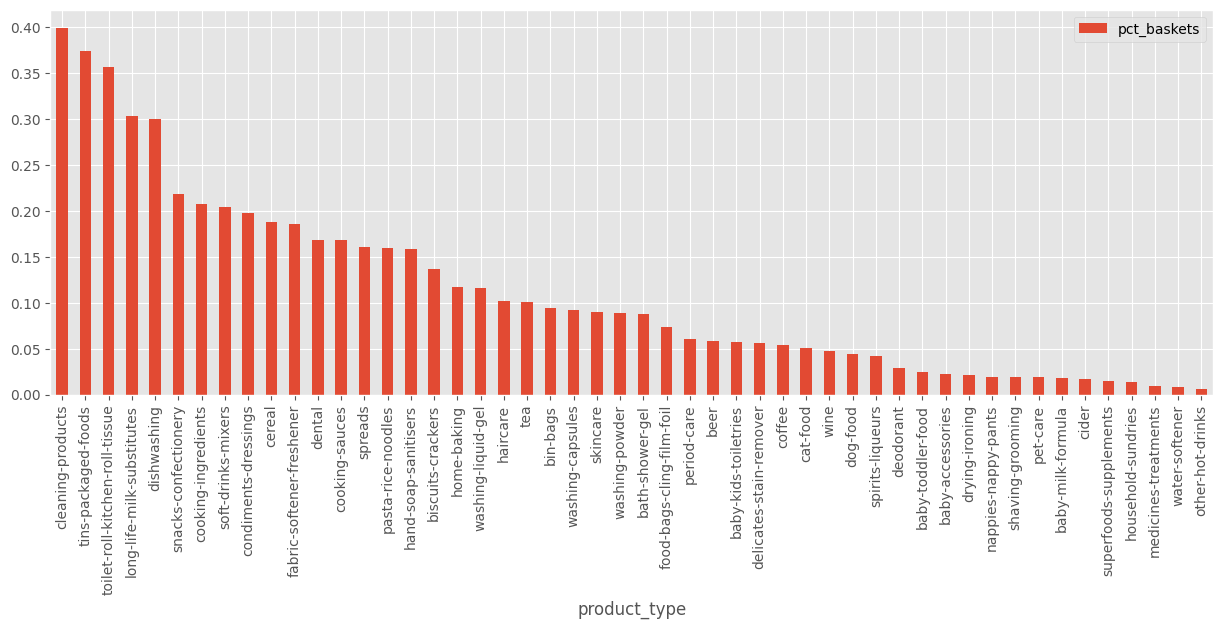

In [327]:
product_type_composition = compute_basket_composition(order_items,"product_type")
product_type_composition.sort_values(ascending=False, by="n_baskets").head(50).plot(
    x="product_type", y="pct_baskets", kind="bar", figsize=(15,5)
)

Por ejemplo **cleaning_products** aparece en 3500 cestas/pedidos, que representa el 39.9% de las cestas

<Axes: xlabel='variant_id'>

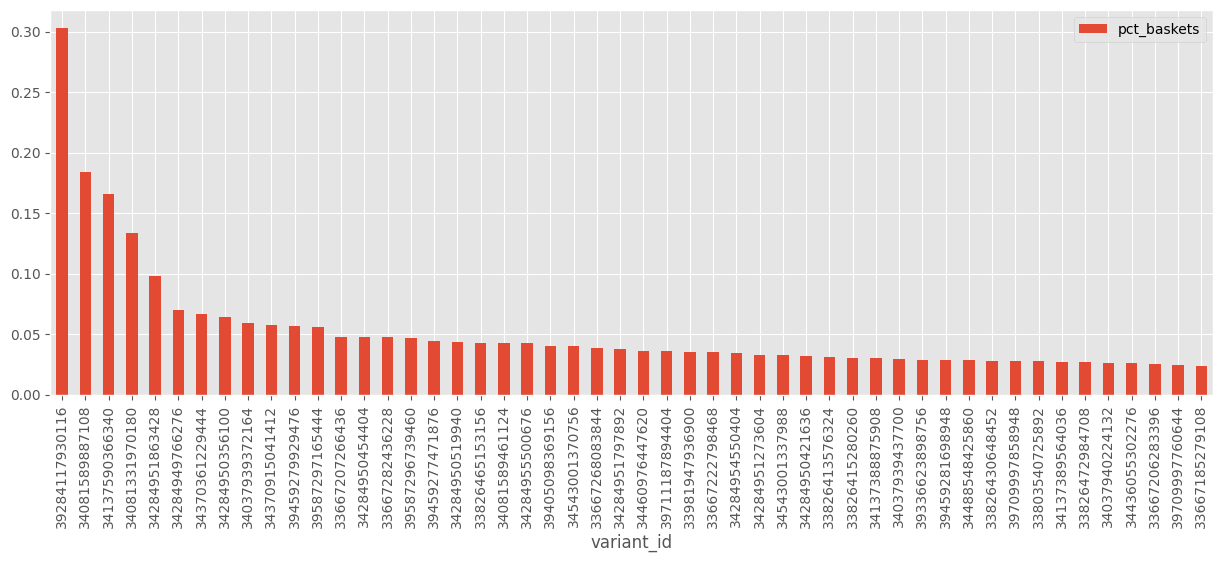

In [328]:
variant_id_type_composition = compute_basket_composition(order_items,"variant_id")
variant_id_type_composition.sort_values(ascending=False, by="n_baskets").head(50).plot(
    x="variant_id", y="pct_baskets", kind="bar", figsize=(15,5)
)

In [358]:
top_5_products = (
    variant_id_type_composition.sort_values(ascending=False, by="n_baskets")
    .head(5)
    .variant_id.values
)
top_5_products

array([39284117930116, 34081589887108, 34137590366340, 34081331970180,
       34284951863428])

In [365]:
inventory.loc[inventory.variant_id == 34081589887108]

,variant_id,price,compare_at_price,vendor,product_type,tags
63,34081589887108,10.79,11.94,oatly,long-life-milk-substitutes,"[oat-milk, vegan]"


In [366]:
inventory.loc[lambda df:df.variant_id.isin(top_5_products)]

,variant_id,price,compare_at_price,vendor,product_type,tags
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
63,34081589887108,10.79,11.94,oatly,long-life-milk-substitutes,"[oat-milk, vegan]"


In [ ]:
order_items.groupby(["id","order_date"])[]

## EDA

In [2]:
bb_df = pd.read_parquet("data/raw/EDA/feature_frame.parquet")

In [3]:
bb_df

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880547,33826439594116,healthcarevitamins,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [12]:
bb_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [6]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [8]:
bb_df.isna().sum()

variant_id                          0
product_type                        0
order_id                            0
user_id                             0
created_at                          0
order_date                          0
user_order_seq                      0
outcome                             0
ordered_before                      0
abandoned_before                    0
active_snoozed                      0
set_as_regular                      0
normalised_price                    0
discount_pct                        0
vendor                              0
global_popularity                   0
count_adults                        0
count_children                      0
count_babies                        0
count_pets                          0
people_ex_baby                      0
days_since_purchase_variant_id      0
avg_days_to_buy_variant_id          0
std_days_to_buy_variant_id          0
days_since_purchase_product_type    0
avg_days_to_buy_product_type        0
std_days_to_

In [9]:
bb_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [42]:
info_cols = ["variant_id","order_id","user_id","created_at","order_date"]
label_col = "outcome"
feature_cols = [col for col in bb_df.columns if col not in info_cols + [label_cols]]

categorical_cols = ["product_type","vendor"]
binary_cols = ["ordered_before","abandoned_before","active_snoozed","set_as_regular"]
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [19]:
bb_df[label_col].value_counts()

outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64

In [20]:
numerical_cols

['user_order_seq',
 'ordered_before',
 'normalised_price',
 'discount_pct',
 'global_popularity',
 'count_adults',
 'count_children',
 'count_babies',
 'count_pets',
 'people_ex_baby',
 'days_since_purchase_variant_id',
 'avg_days_to_buy_variant_id',
 'std_days_to_buy_variant_id',
 'days_since_purchase_product_type',
 'avg_days_to_buy_product_type',
 'std_days_to_buy_product_type']

In [46]:
for col in binary_cols:
    print(f"Value counts {col}: {bb_df[col].value_counts().to_dict()}")
    print(f"Mean outcome by {col} value: {bb_df.groupby(col)['outcome'].mean().to_dict()}")
    print("---")

Value counts ordered_before: {0.0: 2819658, 1.0: 60891}
Mean outcome by ordered_before value: {0.0: 0.008223337723936732, 1.0: 0.1649669080816541}
---
Value counts abandoned_before: {0.0: 2878794, 1.0: 1755}
Mean outcome by abandoned_before value: {0.0: 0.011106039542947498, 1.0: 0.717948717948718}
---
Value counts active_snoozed: {0.0: 2873952, 1.0: 6597}
Mean outcome by active_snoozed value: {0.0: 0.011302554809544488, 1.0: 0.1135364559648325}
---
Value counts set_as_regular: {0.0: 2870093, 1.0: 10456}
Mean outcome by set_as_regular value: {0.0: 0.010668992259135854, 1.0: 0.24971308339709258}
---


- Clases desbalanceadas
- Features que indican si el usuario había interactuado antes con el producto (ordered, abandoned, snoozed, set_as_regular) también muy desbalanceadas
- Todas están fuertemente relacionadas con 'outcome'

In [50]:
bb_df.groupby(col)['outcome'].mean()

set_as_regular
0.0    0.010669
1.0    0.249713
Name: outcome, dtype: float64

<Axes: >

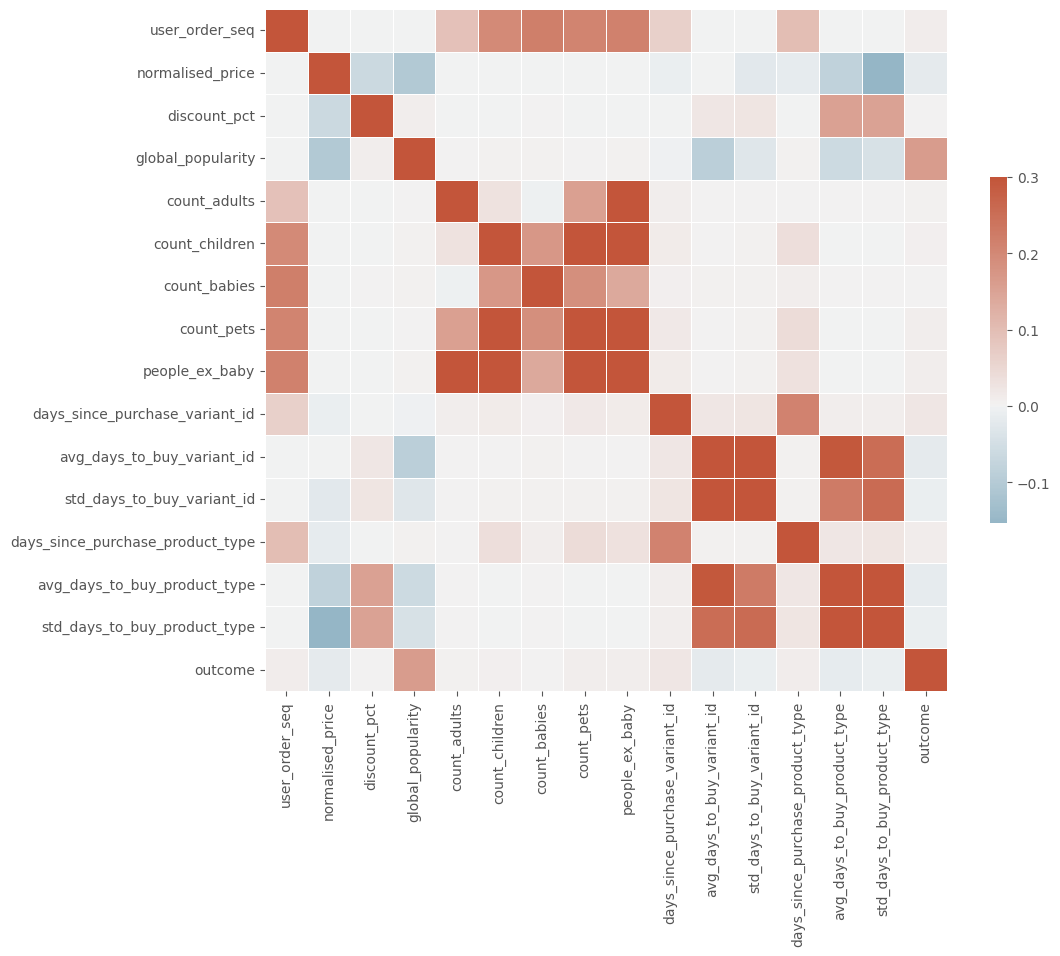

In [60]:
corr = bb_df[numerical_cols + [label_col]].corr()

fig, ax = plt.subplots(figsize=(11,9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidth=0.5,
    cbar_kws={"shrink":0.5}
)